In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import bioframe as bf
from IPython.display import Image


def bedpe_to_bed(df):
    """
    Extract unique bed regions from bedpe dataframe. Index is ignored.
    """
    df_reg1 = df[['chrom1', 'start1', 'end1', 'genes1']]
    df_reg2 = df[['chrom2', 'start2', 'end2', 'genes2']]

    df_reg1.columns = df_reg1.columns.str.rstrip('1')
    df_reg2.columns = df_reg2.columns.str.rstrip('2')

    df_bed = pd.concat([df_reg1, df_reg2], ignore_index=True)\
               .drop_duplicates(ignore_index=True)
    
    return df_bed

# Matplotlib settings
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

In [13]:
!ls

cache				     euler-dot_annotation.EN-IN-manual.pdf
combine_dot_annotation.ipynb	     euler-dot_annotation.EN-IN-manual.png
EN_tian_0.65_filter_13.06.25.csv.gz  IN_tian_0.8_filter_13.06.25.csv.gz


In [2]:
# Set paths to input annotations

# Automatic annotations
auto_path = {
    "EN": "/tank/projects/polycomb/results/2025.06.14/EN_tian_0.65_filter_13.06.25.csv.gz",
    "IN": "/tank/projects/polycomb/results/2025.06.14/IN_tian_0.8_filter_13.06.25.csv.gz"
}

# Manual annotation
man_anch_path = "/tank/projects/polycomb/data/Supp.Table_polycomb_dot_anchors.5kb.xlsx"

# Output combined annotation
out_path = "/tank/projects/polycomb/data/polycomb_dot_anchors.5kb.16_06_25.csv"

In [3]:
# Load automatic annotation (2D - dots)
# For a given anchor, coordinates in columns "start1", "end1", "start2", "end2"
# are identical in EN and IN annotations
auto_df = {ct: pd.read_csv(path).drop(columns=f'vals_100k_{ct}') 
           for ct, path in auto_path.items()}

# Chromosomes 19 and 20 have bright chromatin compartments that get
# annotated as Polycomb dots. To avoid this, we remove these chromosomes 
# from automatic annotation. Similarly, cluster of PCDHG genes is wrongly 
# annotated as polycomb dots (manual validation), therefore, these genes are removed.
comp_chroms = ['chr19', 'chr20']
comp_genes = ['PCDHGA2', 'PCDHGA1', 'PCDHGB1', 'PCDHGA3', 'PCDHGB2', 'PCDHB13', 'PCDHGB3', 'PCDHGB5']
for ct in ['EN', 'IN']:
    auto_df[ct] = auto_df[ct].loc[~auto_df[ct]['chrom1'].isin(comp_chroms) & 
                                  ~auto_df[ct]['chrom2'].isin(comp_chroms) &
                                  ~auto_df[ct]['genes1'].isin(comp_genes) &
                                  ~auto_df[ct]['genes2'].isin(comp_genes)]
    print(ct, auto_df[ct].shape[0])

# Polycomb dots anchoring more than two genes are listed several times with
# different genes. Here we fix this by grouping identical dots and arranging genes
# in a comma-separated list.
group_cols = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
agg_cols = [col for col in auto_df[ct].columns if col not in group_cols]
for ct in ['EN', 'IN']:
    agg_cols = [col for col in auto_df[ct].columns if col not in group_cols]
    auto_df[ct] = auto_df[ct].groupby(group_cols, as_index=False).agg({
        col: lambda x: ','.join(sorted(set(x.astype(str)))) for col in agg_cols
    })
    print(ct, auto_df[ct].shape[0])

auto_df['EN'].head()

EN 495
IN 700
EN 412
IN 592


,chrom1,start1,end1,chrom2,start2,end2,higlass,promoters,pred_EN,genes1,genes2,gene.id1,gene.id2,dot_EN
0,chr1,47230000,47240000,chr1,50420000,50430000,chr1:47230000-47240000 & chr1:50420000-50430000,chr1:47230225-47234226 & chr1:50421443-50425444,0.974967271,TAL1,DMRTA2,ENSG00000162367,ENSG00000142700,1.0
1,chr1,47230000,47240000,chr1,75120000,75130000,chr1:47230000-47240000 & chr1:75120000-75130000,chr1:47230225-47234226 & chr1:75126432-75130433,0.655060028,TAL1,LHX8,ENSG00000162367,ENSG00000162624,1.0
2,chr1,47230000,47240000,chr1,90710000,90720000,chr1:47230000-47240000 & chr1:90710000-90720000,chr1:47230225-47234226 & chr1:90715302-90719303,0.738615859,TAL1,BARHL2,ENSG00000162367,ENSG00000143032,1.0
3,chr1,50420000,50430000,chr1,75120000,75130000,chr1:50420000-50430000 & chr1:75120000-75130000,chr1:50421443-50425444 & chr1:75126432-75130433,0.824874764,DMRTA2,LHX8,ENSG00000142700,ENSG00000162624,1.0
4,chr1,50420000,50430000,chr1,90710000,90720000,chr1:50420000-50430000 & chr1:90710000-90720000,chr1:50421443-50425444 & chr1:90715302-90719303,0.999669527,DMRTA2,BARHL2,ENSG00000142700,ENSG00000143032,1.0


In [4]:
# Extract unique dot anchors from automatic annotation
auto_anch = {ct: bedpe_to_bed(df) for ct, df in auto_df.items()}
for ct in ['EN', 'IN']:
    print(ct, auto_anch[ct].shape[0])
    
auto_anch_mrg = pd.merge(auto_anch['EN'], auto_anch['IN'], how='outer', indicator='EN_IN')
auto_anch_mrg['EN'] = auto_anch_mrg['EN_IN'].apply(lambda x: True if x in ['left_only', 'both'] else False)
auto_anch_mrg['IN'] = auto_anch_mrg['EN_IN'].apply(lambda x: True if x in ['right_only', 'both'] else False)
auto_anch_mrg.drop(columns=['EN_IN'], inplace=True)
auto_anch_mrg = bf.expand(auto_anch_mrg, 10001) # allow error when overlap
auto_anch_mrg.head()

EN 150
IN 199


,chrom,start,end,genes,EN,IN
0,chr1,47219999,47250001,TAL1,True,True
1,chr1,50409999,50440001,DMRTA2,True,True
2,chr1,75109999,75140001,LHX8,True,True
3,chr1,90699999,90730001,BARHL2,True,True
4,chr1,118969999,119000001,TBX15,True,True


In [5]:
# Load manual annotation (1D - dot anchors)
man_anch = pd.read_excel(man_anch_path, na_values=['-'])\
    .dropna(subset=['start_new', 'end_new'])
man_anch[['start', 'end']] = man_anch[['start_new', 'end_new']].astype(int)
man_anch = man_anch.drop(columns=['start_new', 'end_new'])

print(man_anch.shape[0])
man_anch.head()

240


,chrom,start,end,genes
0,chr1,18630000,18640000,PAX7
1,chr1,24930000,24940000,RUNX3
2,chr1,44410000,44420000,RNF220
3,chr1,46480000,46490000,NaN
4,chr1,47180000,47250000,"TAL1,AL135960.1"


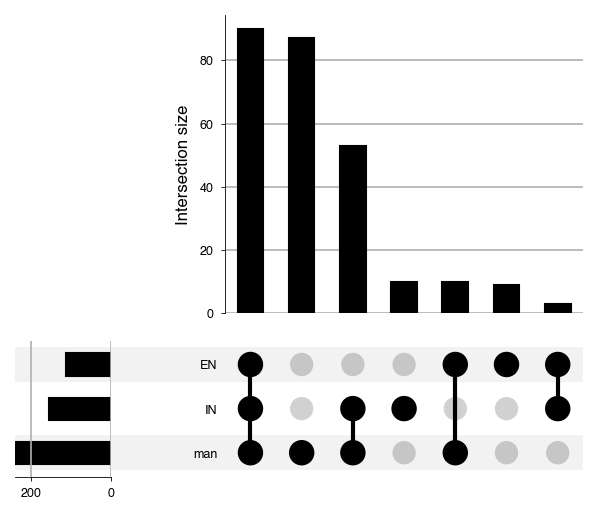

In [6]:
"""
Overlap automatic and manual annotation

When one anchor from one annotation (automatic or manual) overlaps more than one
anchor from another annotation, MANUALLY annotated anchors are kept. This reflects
our observation that manual annotation is more trustworthy.

Example:
---------- 1 manually annotated anchor
--  -- --- 3 automatically annotated anchors in the same locus
-> we replace automatically annotated anchors with manually annotated one
and count number of overlaps as 1.
"""
from upsetplot import plot


# Overlap two dataframes
auto_man_olap = bf.overlap(auto_anch_mrg, man_anch, how='inner', return_index=True, 
                           suffixes=['_auto', '_man'])
auto_olap_idx = auto_man_olap['index_auto'].unique()

man_idx_map = auto_man_olap[['index_man', 'EN_auto', 'IN_auto']].groupby('index_man').any()
man_anch[['EN', 'IN']] = False
man_anch.loc[man_idx_map.index, ['EN', 'IN']] = man_idx_map.values
man_anch[['EN', 'IN']] = man_anch[['EN', 'IN']].fillna(False)
man_anch['man'] = True

auto_anch_mrg['man'] = False
auto_olap_idx = auto_man_olap['index_auto'].unique()
auto_anch_no_man = auto_anch_mrg.loc[auto_anch_mrg.index.difference(auto_olap_idx)]
auto_anch_no_man = bf.expand(auto_anch_no_man, -10001) # return values

# Add anchors from manual annotation that are absent from automatic one to 
# automatic annotation to get complete table
ann_comb = pd.concat([man_anch, auto_anch_no_man], ignore_index=True)

# Plot result
vc = ann_comb[['EN', 'IN', 'man']].value_counts()
fig = plt.figure(dpi=150)
plot(vc, sort_by="cardinality", sort_categories_by='-input', fig=fig);

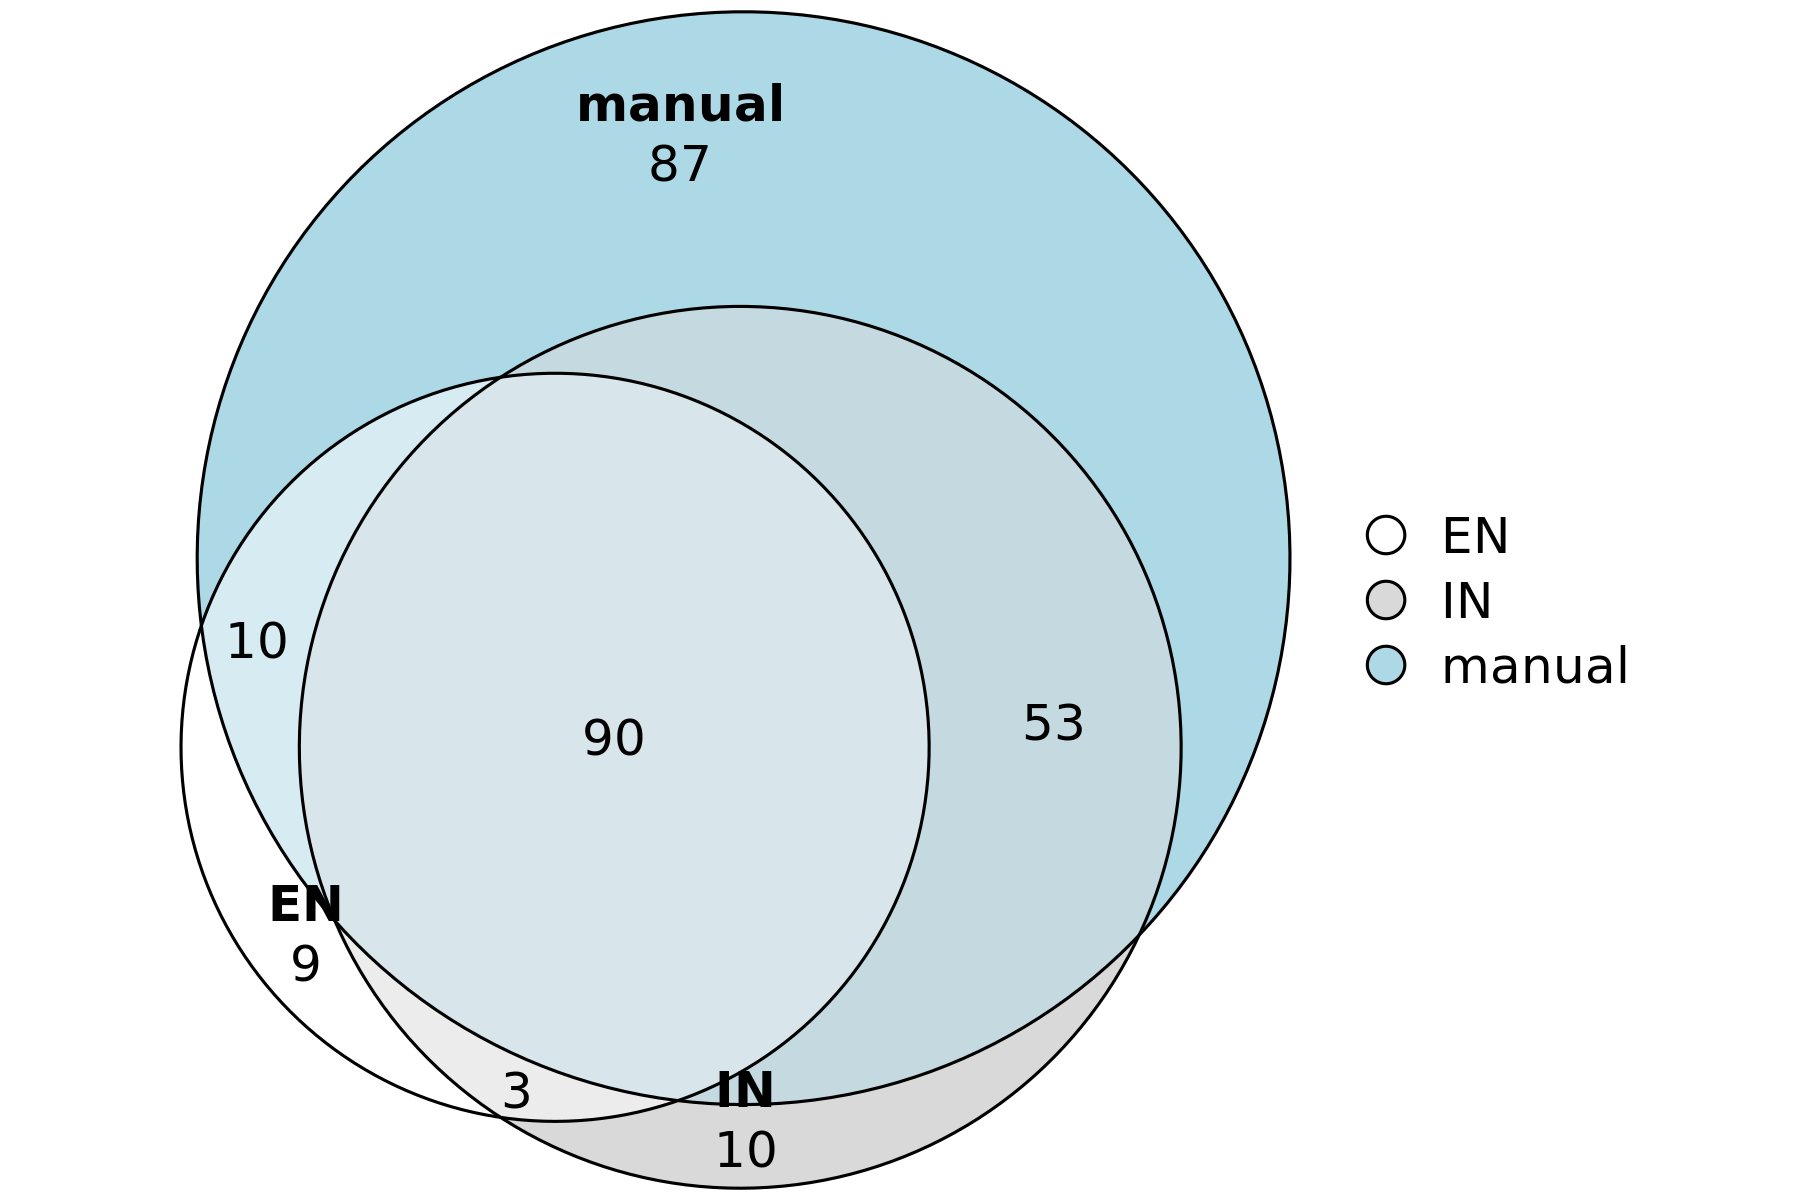

In [7]:
# Venn diagram plotted using https://eulerr.co/
Image("euler-dot_annotation.EN-IN-manual.png", width=500)

In [8]:
vc

EN     IN     man  
True   True   True     90
False  False  True     87
       True   True     53
              False    10
True   False  True     10
              False     9
       True   False     3
Name: count, dtype: int64

In [9]:
print(
    "EN", ann_comb.query('EN == True').shape[0],
    "IN", ann_comb.query('IN == True').shape[0],
    "man", ann_comb.query('man == True').shape[0],
)

EN 112 IN 156 man 240


In [10]:
# Overlap genes from automatic and manual annotation
import re


auto_only_g = ann_comb.query('man == False')['genes'].values
man_g = ann_comb.query('man == True')['genes']

# Extract gene names
hand_genes_all = man_g.dropna().str.split(',').values
hand_genes_all = [item for sublist in hand_genes_all for item in sublist]

[gene for gene in auto_only_g if gene in hand_genes_all]

['MEIS1']

Only MEIS1 is present two times, one in manual annotation and one - in automatic annotation - but these are different anchors

In [11]:
# Save final annotation
ann_comb[['chrom', 'start', 'end', 'genes']].to_csv(out_path, header=True, index=False)